In [519]:
import QuantLib as ql
import matplotlib.pyplot as pltz
import numpy as np

# Enter Variables
### - Hull White Model Variables
### - GBM State Variables

In [520]:
# Hull White Model Variables
sigma = 0.1
a = 0.1
timestep = 12                      # discretize the time span of length 30 years into 360 intervals (one per month)
length = 1                         # in years
forward_rate = 0.05
day_count = ql.Thirty360()
todays_date = ql.Date(13, 5, 2020)

# GBM State Variables
T = timestep
num_paths = 100                    # Path
dt = 0.01                  
S0 = 100
Strike = 95
r = 0.01
np.random.seed(1)

# Hull White Term Structure Simulations
## 對 Hull White Model 模擬 Short Rate
### reference: [Hull White Term Structure Simulations with QuantLib Python](http://gouthamanbalaraman.com/blog/hull-white-simulation-quantlib-python.html)

In [521]:
ql.Settings.instance().evaluationDate = todays_date

spot_curve = ql.FlatForward(todays_date, ql.QuoteHandle(ql.SimpleQuote(forward_rate)), day_count)
spot_curve_handle = ql.YieldTermStructureHandle(spot_curve)

In [522]:
hw_process = ql.HullWhiteProcess(spot_curve_handle, a, sigma)
rng = ql.GaussianRandomSequenceGenerator(ql.UniformRandomSequenceGenerator(timestep, ql.UniformRandomGenerator()))
seq = ql.GaussianPathGenerator(hw_process, length, timestep, rng, False)

In [523]:
def generate_paths(num_paths, timestep):
    arr = np.zeros((num_paths, timestep+1))
    for i in range(num_paths):
        sample_path = seq.next()
        path = sample_path.value()
        time = [path.time(j) for j in range(len(path))]
        value = [path[j] for j in range(len(path))]
        arr[i, :] = np.array(value)
    return np.array(time), arr

# Hull-White Short Rate Simulation graph 

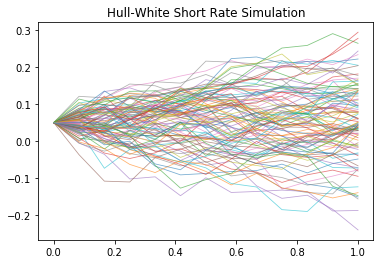

In [524]:
time, paths = generate_paths(num_paths, timestep)
for i in range(num_paths):
    plt.plot(time, paths[i, :], lw=0.8, alpha=0.6)
plt.title("Hull-White Short Rate Simulation")
plt.show()

# Use Geometric Brownian Motion to simulate Stock Price
## 將 Short Rate 帶入 Geometric Brownian Motion，r 換成 r(t) 模擬股價
### reference: [GBM from Pecu Tsai](https://colab.research.google.com/drive/1LL_m1UO_U2oHDMQhBDPjhUBANDpVhev7#scrollTo=NBA3FHuhlVh9)

In [525]:
def genBrownPath(T, mu, sigma, S0, dt):
    S = []
    n = round(T/dt)
    W = [0] + np.random.standard_normal(size = 1) 
    W = (W + np.random.standard_normal(size = 1))*np.sqrt(dt)
    for i in range(len(time)):
        S.append(S0*np.exp((float(mu[i])-0.5*sigma**2)*float(time[i]) + sigma*W)) 
    plt.plot(time, S, lw=0.8, alpha=0.6)
    plt.title("Stock Price Simulation")
    return S

# Stock Price Simulation graph

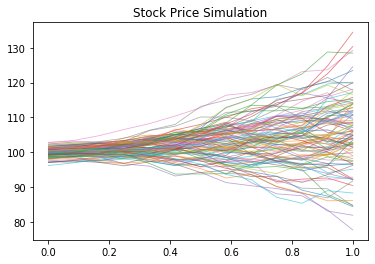

In [533]:
Paths = []
for i in range(num_paths):
    Paths.append(genBrownPath(T, paths[i, :], sigma, S0, dt))

# 對每一條 path 計算出到期日時的 PayOff

In [537]:
p = []
for i in range(num_paths-1):
    Final_price = Paths[i][T]
    p.append(int(Final_price - Strike))
print(p)

[7, 11, 19, 11, 13, 8, 23, 15, 6, 14, -10, 14, 9, 39, -17, 6, 2, 17, 22, 0, 1, 10, 18, 20, 15, 11, 34, -3, 13, 6, 12, 17, 7, 1, -13, 4, 15, -10, 3, 12, 28, 7, 20, 6, 3, -2, 6, 19, 18, 25, 1, 9, 7, -4, 29, 1, 16, 22, 21, 22, 16, -8, 2, 10, 11, 12, 9, 16, 2, 9, 15, 7, 33, -2, -2, 10, -2, 8, 12, -2, 9, 5, -10, 9, 19, 13, 3, 24, 7, 16, 8, 19, 19, 35, 14, 24, 13, 7, 12]


# Calculate Call Price

In [527]:
Pay_off = []
for i in range(num_paths-1):
    Final_price = Paths[i][T]
    if Final_price - Strike > 0:
        X = Final_price - Strike
        Pay_off.append(X + np.exp(-1.0*r*i)*X)
print(np.sum(Pay_off)/num_paths)

19.49259869862335


# Calculate Put Price

In [528]:
Pay_off = []
for i in range(num_paths-1):
    Final_price = Paths[i][T]
    if Strike - Final_price > 0:
        X = Strike - Final_price
        Pay_off.append(X + np.exp(-1.0*r*i)*X)
print(np.sum(Pay_off)/num_paths)

1.3627744276577303
